# Periods in TESS 2-min Data with `Exoplanet`
Combining the latest data wrapper for exoplanet-mission data (`exoplanet` by DFM), with best practices for gathering reliable periods (with Ruth Angus).

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

from astropy.table import Table
import astropy.io.fits as fits

from scipy.optimize import curve_fit

from glob import glob

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

ftype = '.pdf'

import exoplanet as xo

## Gather ye data while ye may
We've already downloaded Sectors 1 and 2 locally, but this could also be done with the fantastic new `lightkurve` package

In [3]:
tess_dir = '/Users/james/Desktop/tess/'

sectors = ['sector001', 'sector002']

# just in case glob wants to re-order things, be sure grab them in Sector order
sect1 = glob(tess_dir + sectors[0] + '/*.fits', recursive=True)
sect2 = glob(tess_dir + sectors[1] + '/*.fits', recursive=True)

files = sect1 + sect2
print(len(sect1), len(sect2), len(files))

15889 15990 31879


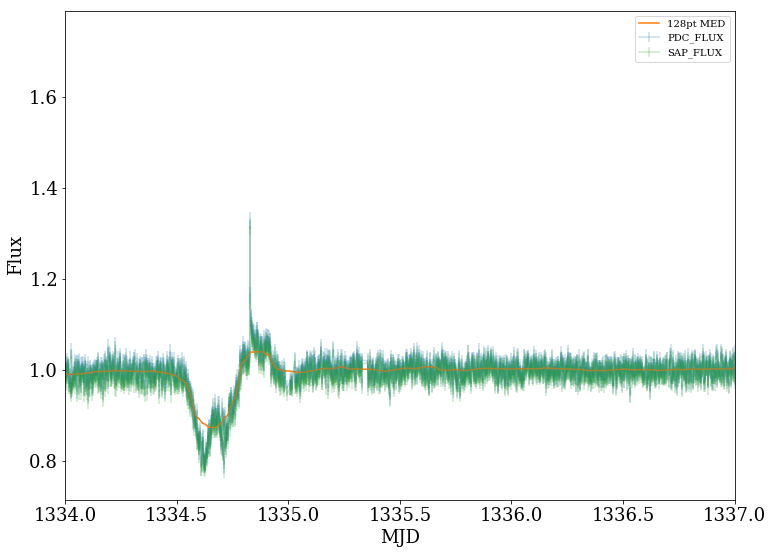

In [46]:
# for k in range(len(files)):
#     try:

# k = 10
# tbl = Table.read(files[k], format='fits')

tbl = Table.read('/Users/james/Desktop/tess/sector001/tess2018206045859-s0001-0000000214516789-0120-s_lc.fits', format='fits')
df = tbl.to_pandas()

# make harsh quality cuts, and chop out a known bad window of time
AOK = (tbl['QUALITY'] == 0) & ((tbl['TIME'] < 1347) | (tbl['TIME'] > 1350))

if sum(AOK) > 1000:

    # do a running median for a basic smooth
    smo = df['PDCSAP_FLUX'][AOK].rolling(128, center=True).median()
    med = np.nanmedian(smo)

    #find OK points in the smoothed LC
    SOK = np.isfinite(smo)

    LS_pks = xo.lomb_scargle_estimator(df['TIME'][AOK][SOK], smo[SOK]/med, 
                                       yerr=df['PDCSAP_FLUX_ERR'][AOK][SOK]/med, 
                                       min_period=0.1, max_period=50, max_peaks=1)

    
    plt.figure(figsize=(12,9))

    plt.errorbar(tbl['TIME'][AOK], tbl['PDCSAP_FLUX'][AOK]/med, yerr=tbl['PDCSAP_FLUX_ERR'][AOK]/med, 
                 linestyle=None, alpha=0.25, label='PDC_FLUX')
    plt.plot(tbl['TIME'][AOK], smo/med, label='128pt MED')

    Smed = np.nanmedian(tbl['SAP_FLUX'][AOK])
    plt.errorbar(tbl['TIME'][AOK], tbl['SAP_FLUX'][AOK]/Smed, yerr=tbl['SAP_FLUX_ERR'][AOK]/Smed, 
                 linestyle=None, alpha=0.25, label='SAP_FLUX')
    plt.xlim(1334,1337)
    
#     if np.nanmax(power) > 0.2:
#         LSmodel = LS.model(df['TIME'][AOK][SOK], best_frequency)
#         plt.plot(df['TIME'][AOK][SOK], LSmodel, label='P='+format(1./best_frequency, '6.3f')+'d')            

#     plt.title(files[k].split('/')[-1], fontsize=12)
    plt.ylabel('Flux')
    plt.xlabel('MJD')
    plt.legend(fontsize=10)
    plt.show()


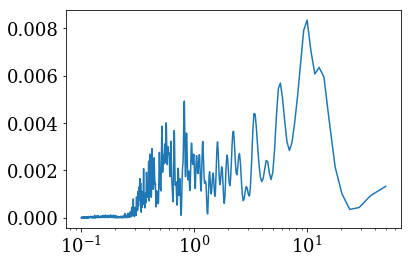

In [35]:
plt.plot(1./LS_pks['periodogram'][0], LS_pks['periodogram'][1])
plt.xscale('log')

In [36]:
LS_pks['peaks']

[{'log_power': -4.778467674683387,
  'period': 9.876487654713301,
  'period_uncert': 1.5061813412915974},
 {'log_power': -5.058802206283008,
  'period': 12.743530111622757,
  'period_uncert': 3.510562203119342},
 {'log_power': -5.165057871003562,
  'period': 5.768491195302646,
  'period_uncert': 0.607111721112148},
 {'log_power': -5.296411229965997,
  'period': 0.8184578099989624,
  'period_uncert': 0.011467511588338648},
 {'log_power': -5.403062284610741,
  'period': 3.4358737304448232,
  'period_uncert': 0.1878385904163215}]